# Face Detection 



```
# Abraham Gil Félix | A01750884
```



## Instalación de dependencias

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importación de librerías

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode

import os
import time
import uuid
import cv2

import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

import albumentations as alb

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## Creación del conjunto de datos

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
"""
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
"""

"\ncap = cv2.VideoCapture(1)\nfor imgnum in range(number_images):\n    print('Collecting image {}'.format(imgnum))\n    ret, frame = cap.read()\n    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')\n    cv2.imwrite(imgname, frame)\n    cv2.imshow('frame', frame)\n    time.sleep(0.5)\n\n    if cv2.waitKey(1) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()\n"

In [ ]:
# Function used in Google - Colaboratory
"""
def take_photo(filename=f'{str(uuid.uuid1())}.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename
"""

"\ndef take_photo(filename=f'{str(uuid.uuid1())}.jpg', quality=0.8):\n  js = Javascript('''\n    async function takePhoto(quality) {\n      const div = document.createElement('div');\n      const capture = document.createElement('button');\n      capture.textContent = 'Capture';\n      div.appendChild(capture);\n\n      const video = document.createElement('video');\n      video.style.display = 'block';\n      const stream = await navigator.mediaDevices.getUserMedia({video: true});\n\n      document.body.appendChild(div);\n      div.appendChild(video);\n      video.srcObject = stream;\n      await video.play();\n\n      // Resize the output to fit the video element.\n      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);\n\n      // Wait for Capture to be clicked.\n      await new Promise((resolve) => capture.onclick = resolve);\n\n      const canvas = document.createElement('canvas');\n      canvas.width = video.videoWidth;\n      canvas.height = video

In [ ]:
"""
try:
  for i in range(number_images):
    filename = take_photo()
    print('Saved to {}'.format(filename))
  # display(Image(filename))

except Exception as err:
  print(str(err))
"""

"\ntry:\n  for i in range(number_images):\n    filename = take_photo()\n    print('Saved to {}'.format(filename))\n  # display(Image(filename))\n\nexcept Exception as err:\n  print(str(err))\n"

## Etiquetado del conjunto de datos

In [ ]:
!labelme

QObject::moveToThread: Current thread (0x1a64060) is not the object's thread (0x1a65890).
Cannot move to target thread (0x1a64060)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.7/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl.



## Carga de los datos

In [ ]:
images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data/images/*.jpg', 
                                    shuffle=False)

images.as_numpy_iterator().next()

b'/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Te\xcc\x81cnicas y arquitecturas de Deep Learning/FaceDetection/data/images/813ae85d-5a30-11ed-81e7-48a472fee137.jpg'

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[152, 178, 177],
        [152, 178, 177],
        [151, 177, 176],
        ...,
        [195, 221, 222],
        [196, 222, 223],
        [197, 223, 224]],

       [[152, 178, 177],
        [152, 178, 177],
        [151, 177, 176],
        ...,
        [193, 221, 222],
        [194, 222, 223],
        [195, 223, 224]],

       [[150, 178, 179],
        [150, 178, 179],
        [149, 178, 176],
        ...,
        [192, 222, 220],
        [192, 222, 220],
        [193, 223, 221]],

       ...,

       [[ 14,  18,  21],
        [ 15,  19,  22],
        [ 16,  20,  21],
        ...,
        [114, 109,  90],
        [122, 117,  97],
        [123, 117,  95]],

       [[ 12,  17,  20],
        [ 13,  18,  21],
        [ 14,  19,  22],
        ...,
        [ 96,  85,  63],
        [110,  98,  74],
        [121, 109,  83]],

       [[ 10,  15,  18],
        [ 11,  16,  19],
        [ 13,  18,  21],
        ...,
        [ 54,  42,  18],
        [ 66,  50,  25],
        [ 79,  63,  37]]

In [ ]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### Visualización de los datos

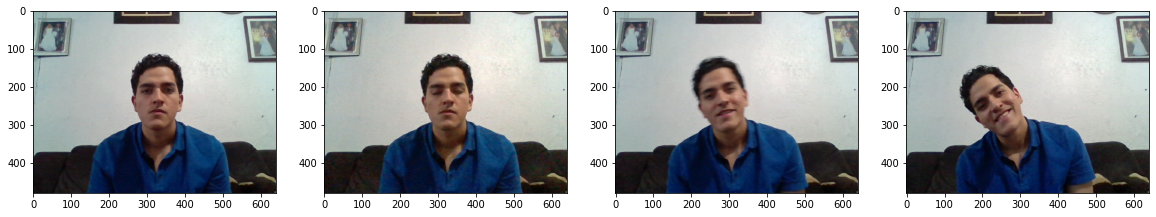

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Partición de los datos

In [ ]:
# train set
print("train set: ", round(90*.7, 2)) # 63

train set:  63.0


In [ ]:
# validation set
print("train set: ", round(90*.13, 2)) # 12

train set:  11.7


In [ ]:
# test set
print("train set: ", round(90*.17, 2)) # 15

train set:  15.3


### Match labels-images

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

## Expansión del conjunto de datos

In [ ]:
# Size of the images
img = cv2.imread('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data/train/images/813ae85d-5a30-11ed-81e7-48a472fee137.jpg')
img.shape

(480, 640, 3)

### Transformación de una imagen

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [ ]:
# with open(os.path.join('data', 'train', 'labels', 'ffd85fc5-cc1a-11ec-bfb8-a0cec8d2d278.json'), 'r') as f:
with open('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data/train/labels/813ae85d-5a30-11ed-81e7-48a472fee137.json', 'r') as f:
    label = json.load(f)

In [ ]:
type(label)

dict

In [ ]:
label['shapes']

[{'label': 'Abraham',
  'points': [[241.5328467153285, 108.61313868613138],
   [408.68613138686135, 323.2116788321168]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

In [ ]:
# Coordinates
label['shapes'][0]['points']

[[241.5328467153285, 108.61313868613138],
 [408.68613138686135, 323.2116788321168]]

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

[241.5328467153285, 108.61313868613138, 408.68613138686135, 323.2116788321168]

In [ ]:
# 480 x 640 image size
coords = list(np.divide(coords, [640,480,640,480]))

In [ ]:
coords

[0.3773950729927008,
 0.2262773722627737,
 0.6385720802919709,
 0.6733576642335766]

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Abraham'])

In [ ]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [ ]:
augmented['bboxes'][0][2:]

(0.6859691808596918, 0.8164152473641525)

In [ ]:
augmented['bboxes']

[(0.31451743714517444,
  0.3395296025952961,
  0.6859691808596918,
  0.8164152473641525)]

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

array([[[ 34,  27,  30],
        [ 34,  27,  30],
        [ 35,  28,  31],
        ...,
        [ 12,   7,  11],
        [ 13,   5,  12],
        [ 12,   4,  11]],

       [[ 35,  28,  31],
        [ 35,  28,  31],
        [ 36,  29,  32],
        ...,
        [ 12,   7,  11],
        [ 13,   5,  12],
        [ 11,   3,  10]],

       [[ 33,  29,  31],
        [ 33,  29,  31],
        [ 32,  28,  28],
        ...,
        [ 14,   8,  15],
        [ 13,   5,  12],
        [ 11,   3,  10]],

       ...,

       [[ 98,  92,  82],
        [125, 119, 109],
        [155, 149, 139],
        ...,
        [226, 224, 202],
        [223, 223, 199],
        [221, 220, 198]],

       [[100,  95,  83],
        [124, 119, 107],
        [155, 150, 138],
        ...,
        [225, 224, 200],
        [222, 221, 199],
        [221, 220, 198]],

       [[ 98,  93,  81],
        [120, 115, 102],
        [153, 148, 135],
        ...,
        [222, 221, 197],
        [221, 220, 198],
        [220, 219, 197]]

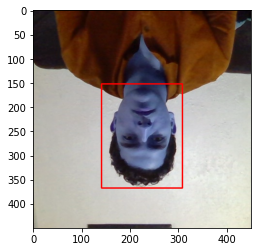

In [ ]:
plt.imshow(augmented['image'])

### Transformación para train, test and validation set

In [ ]:
"""
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', partition, 'images')):
        img = cv2.imread(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
"""

x_max is less than or equal to x_min for bbox [0.4401231751824818, 0.2338807785888078, 0.16411952554744527, 0.6125304136253041, 'face'].
x_max is less than or equal to x_min for bbox [0.46977645985401467, 0.2095498783454988, 0.2736085766423358, 0.5684306569343066, 'face'].
x_max is less than or equal to x_min for bbox [0.19263229927007303, 0.4406934306569343, 9.581528297040177e-05, 0.9979166666666667, 'face'].


### Carga de los nuevos conjuntos de datos

In [ ]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

### Match labels-images

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3784, 0.3083, 0.75  , 0.785 ], dtype=float16))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5894, 0.3035, 0.917 , 0.683 ], dtype=float16))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8), array([0.   , 0.   , 0.281, 0.409], dtype=float16))

## Conjuntos de datos finales

In [ ]:
# Size of the datasets
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 720, 720)

### Entrenamiento

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
# 8 images
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0]], dtype=uint8), array([[0.0468, 0.3198, 0.5156, 0.7563],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2644, 0.2888, 0.612 , 0.7544],
        [0.    , 0.2573, 0.3188, 0.812 ],
        [0.7256, 0.235 , 1.    , 0.7896],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2632, 0.2854, 0.7354, 0.871 ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [ ]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(800)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
val.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8), array([[0.742 , 0.2296, 1.    , 0.6597],
        [0.33  , 0.328 , 0.671 , 0.72  ],
        [0.    , 0.1609, 0.3   , 0.568 ],
        [0.4607, 0.3035, 0.7886, 0.683 ],
        [0.362 , 0.2534, 0.737 , 0.693 ],
        [0.2183, 0.2944, 0.546 , 0.6743],
        [0.3364, 0.1692, 0.729 , 0.6753],
        [0.6743, 0.3281, 1.    , 0.7773]], dtype=float16))

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1200)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
test.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1]], dtype=uint8), array([[0.2407, 0.1112, 0.6025, 0.4795],
        [0.4302, 0.2678, 0.7935, 0.691 ],
        [0.09  , 0.3335, 0.5444, 0.945 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2583, 0.147 , 0.714 , 0.6772],
        [0.1029, 0.4883, 0.4597, 0.897 ]], dtype=float16))

### Visualización

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

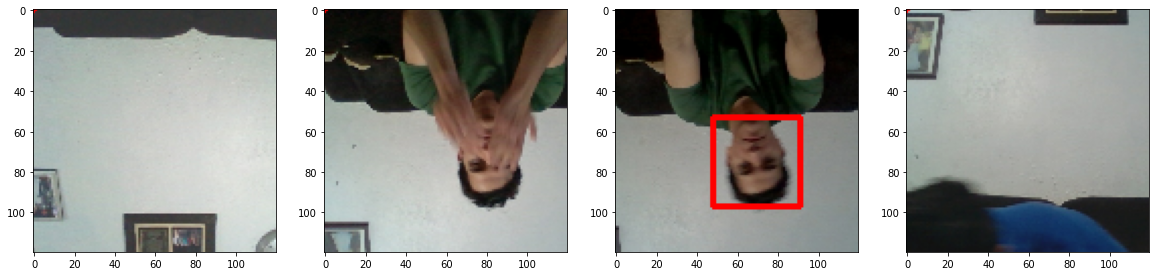

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Modelación NN

### Arquitectura VGG16

In [ ]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Modelo

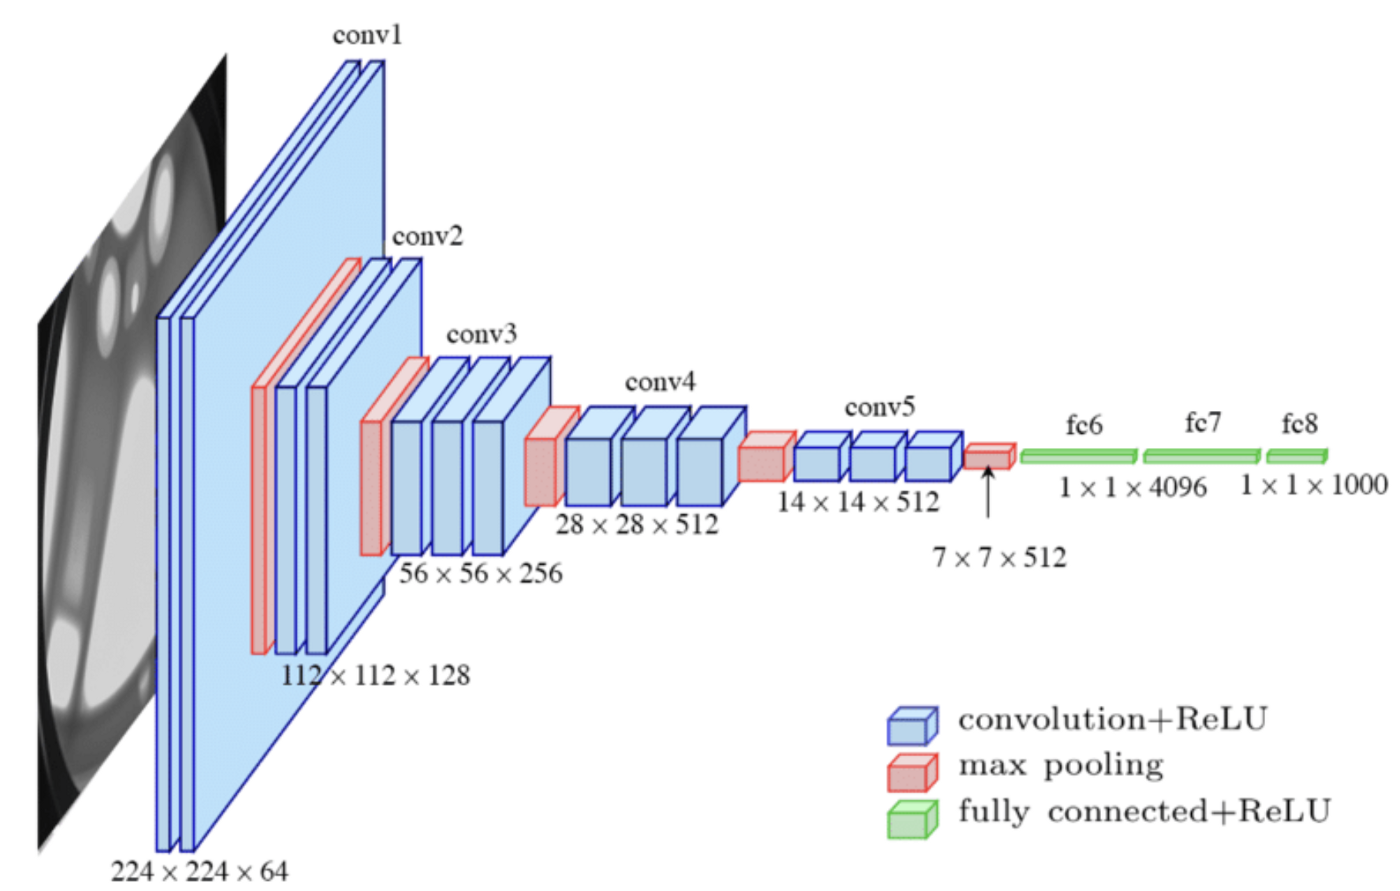

Red Neuronal Profunda ---> VGG + modelo de clasificación y modelo de regresión

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3)) # image dimensions
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # binary classification
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 coordinates
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [ ]:
classes, coords

(array([[0.34444043],
        [0.3343517 ],
        [0.41926095],
        [0.40470293],
        [0.41535637],
        [0.51447886],
        [0.3677655 ],
        [0.3566372 ]], dtype=float32),
 array([[0.54123706, 0.5018872 , 0.42837942, 0.45950764],
        [0.5836584 , 0.46532792, 0.34407017, 0.49410474],
        [0.598537  , 0.58913904, 0.32841697, 0.47103143],
        [0.56045604, 0.55475897, 0.40885216, 0.48665112],
        [0.57347715, 0.44866708, 0.3514005 , 0.58886796],
        [0.53192675, 0.48255697, 0.3614981 , 0.4385087 ],
        [0.58744484, 0.37441164, 0.39655167, 0.476222  ],
        [0.57417905, 0.48450512, 0.41845077, 0.46494704]], dtype=float32))

### Optimizador y LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### Funciones de pérdida (Loss)

In [ ]:
# Localization Loss and Classification Loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.72947776>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0009813>

## Entrenamiento NN

### Clase - Modelo NN 

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

### Performance

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
450/450 [==============================] - 49s 71ms/step - total_loss: 0.3356 - class_loss: 0.0968 - regress_loss: 0.2872 - val_total_loss: 0.1177 - val_class_loss: 4.0493e-04 - val_regress_loss: 0.1175
Epoch 2/40
450/450 [==============================] - 43s 68ms/step - total_loss: 0.0805 - class_loss: 0.0266 - regress_loss: 0.0672 - val_total_loss: 0.0699 - val_class_loss: 2.2898e-04 - val_regress_loss: 0.0697
Epoch 3/40
450/450 [==============================] - 43s 68ms/step - total_loss: 0.0487 - class_loss: 0.0146 - regress_loss: 0.0414 - val_total_loss: 0.0845 - val_class_loss: 3.0320e-04 - val_regress_loss: 0.0843
Epoch 4/40
450/450 [==============================] - 43s 68ms/step - total_loss: 0.0210 - class_loss: 0.0077 - regress_loss: 0.0171 - val_total_loss: 0.0216 - val_class_loss: 4.9213e-04 - val_regress_loss: 0.0213
Epoch 5/40
450/450 [==============================] - 47s 68ms/step - total_loss: 0.0226 - class_loss: 0.0097 - regress_loss: 0.0177 - val_total

In [ ]:
hist.history

{'total_loss': [0.02338200807571411,
  0.018611444160342216,
  0.03520230948925018,
  0.009946172125637531,
  0.0031166800763458014,
  0.011767036281526089,
  0.04063393175601959,
  0.007935796864330769,
  0.03365277871489525,
  0.0030809275340288877,
  0.003208273323252797,
  0.0017791689606383443,
  0.005060180090367794,
  0.0011596799595281482,
  0.0009932279353961349,
  0.0014490492176264524,
  0.00367469503544271,
  0.0001126191345974803,
  0.0008682625484652817,
  0.008773518726229668,
  0.0011112471111118793,
  0.0025204767007380724,
  0.0007513182936236262,
  0.000391789129935205,
  0.0014959711115807295,
  0.00035905634285882115,
  0.0007468773983418941,
  0.0007945429533720016,
  0.0022501968778669834,
  0.0013268394395709038,
  0.0012064266484230757,
  0.0002972876245621592,
  0.0003410305071156472,
  0.0006261039525270462,
  0.00032060002558864653,
  0.00021403802384156734,
  0.0004209652543067932,
  5.300643533701077e-05,
  0.00034191293525509536,
  9.949339437298477e-05],

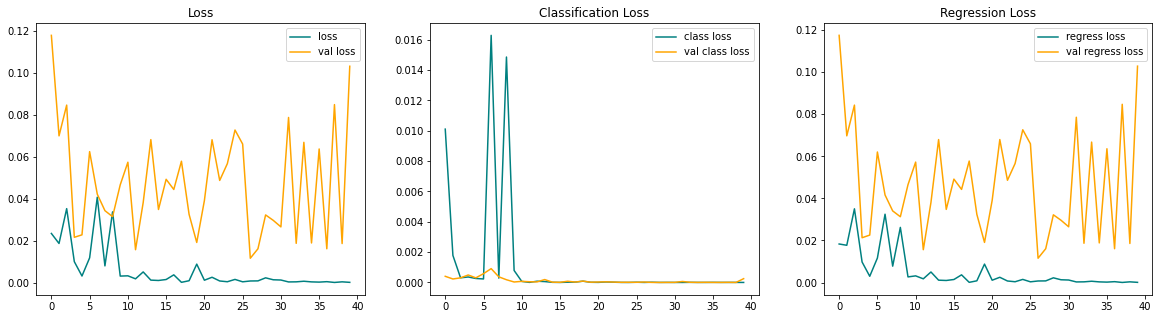

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Predicciones

### Test set

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 20ms/step


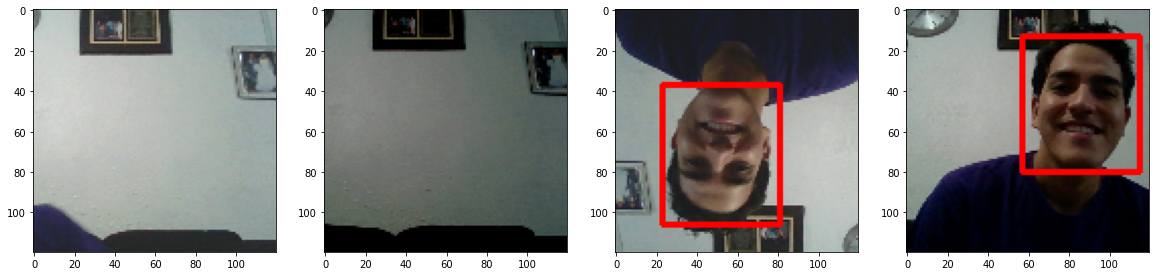

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Exportación del Modelo

In [ ]:
facetracker.save('FaceDetectionModel.h5')

## Importación del Modelo

In [ ]:
facetracker = load_model('/content/drive/MyDrive/7MO SEMESTRE/Inteligencia Artificial Avanzada para la Ciencia de Datos II/M2. Técnicas y arquitecturas de Deep Learning/FaceDetection/FaceDetectionModel.h5')

# Real Time Face Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Abraham', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()